In [149]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Contents

* [Executive Summary](#Executive-Summary)
* [fc1000 Feature Engineering](fc1000-Feature-Engineering)
* [Base Model](#Base-Model)
* [PCA Based Model](#PCA-Based-Model)
* [High Frequency Classes](#High-Frequency-Classes)
* [High Frequency With PCA](#High-Frequency-with-PCA)
* [Analyze Iterations at High Frequency and PCA](#Analyze-Iterations-at-High-Frequency-and-PCA)
* [Anayze Learning Curve](#Analyze-Learning-Curve)

# Executive Summary

Our final Spiral 1 model has achieved an accuracy of 62% accuracy after 5 fold CV. This was achieved after 
- Only looking at the 4 classes with the highest frequency (FBFM1, FBFM2, FBFM5, Urban)
- Reducing the number of features from 1000 to 400 via PCA (capturing 98% variance)

Below shows the iterations of the Spiral 1 model along with their 5 fold CV validation scores:

| Model | Score   |
|------|------|
|   Base Model  | 55.64% |
|   PCA Based Model  | 56.64% |
|   High Frequency Classes  | 57.62% |
|   High Frequency with PCA  | 61.23% |
|   Alter Iterations at High Frequency and PCA  | 62.02% |

The follow evidence shows that the final model is suffering from high variance:
- The optimal parameters from GridSearchCV are higher than default number of iterations and no penality for regularization. This indicates the model wishes to grow more complex to understand the underlying results better. 
- The learning curve is converging at 100% but the validation score flattens out. Under a high bias or overfit condition, there would be a significant gap between the 2 score curves.

This high variance in our resulting model indicates that the Spiral 1 model is not complex enough. Increasing the complexity of the model (i.e. use a more complex linear model or even a non-linear model) will help improve the accuracy of our model.

# fc1000 Feature Engineering

#### Importing Libraries

In [1]:
# from skicaffe import SkiCaffe
import sys, os, random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import normalize
%matplotlib inline

In [2]:
import sklearn
sklearn.__version__

'0.18.1'

#### Set Caffe root

The Caffe binary paths are based on the binaries provided by John. The pre-trained ResNet-50 can be found here:
https://github.com/KaimingHe/deep-residual-networks

#### Inception Model

Setting up a Deep Learning model based on ResNet-50 that has been pre-trained on ImageNet data for our Inception Model. Check appropriate layer name here:
http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006

#### Feature Engineering

Passing WIFIRE data through the Inception Model for Feature Engineering.

Since processing takes forever, the dataframe and engineered features are stored in csv files.

#### Classification

The engineered features are classified using a linear classifier. Based on available memory, the Logistic Classifier calculates the weights either by matrix manipulation or Stochastic Gradient Descent.

In [3]:
root = "/home/ssnazrul/WIFIRE/ResNet50_Analysis/WIFIRE_Engineered/"

image_features = pd.read_csv(root+"WIFIRE_fc1000_engineered_features.csv",  delimiter=',', header=None)
df = pd.read_csv(root+'WIFIRE_labels.csv')
labels = df.Labels.values

# Base Model

The base model uses SGD's default parameters at 5 fold cross validation.

In [97]:
n_samples = len(df)
X = normalize(image_features.values)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [98]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1)
parameters =  {'loss':('hinge',)}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={'loss': ('hinge',)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [99]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [100]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

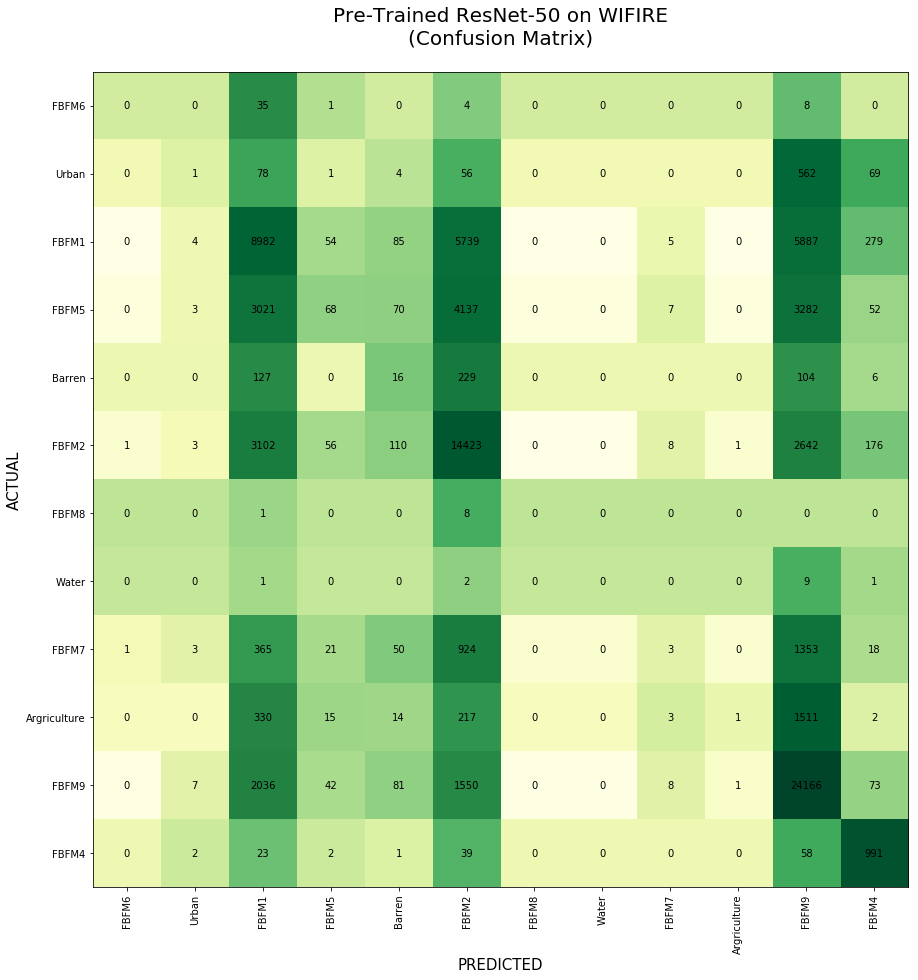

In [101]:
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = df.Labels.unique()
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on WIFIRE\n(Confusion Matrix)\n', fontsize=20);

Poor classification achieved. The confusion matrix is very... 

CONFUSING!!! (pun intended.. *badam tiss*)

#### Validation Score

In [102]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

55.645022932369528

# PCA Based Model

#### Original Dimensions

In [125]:
from sklearn.decomposition import PCA

M = normalize(image_features.values)

pca = PCA(n_components=np.shape(M)[1]) 
T = pca.fit_transform(M) 
T.shape

(437153, 1000)

#### Variance Captured by PCA

[ 0.30963803  0.11017469  0.07313318  0.05002274  0.03667691  0.02285345
  0.02043407  0.01885264  0.01628367  0.0154002 ]


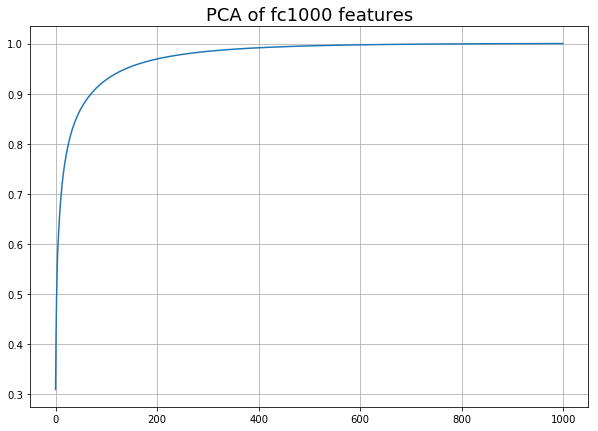

In [126]:
cumulative_explained = np.cumsum(pca.explained_variance_ratio_) 
plt.figure(figsize=(10,7))
plt.plot(cumulative_explained);
#xlim([0,365])
plt.grid()
plt.title('PCA of fc1000 features', fontsize=18)

print(pca.explained_variance_ratio_[:10])

In [127]:
pca = PCA(n_components=400) 
T = pca.fit_transform(M) 

In [128]:
n_samples = len(df)
X = normalize(T)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [129]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2')}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'loss': ('hinge', 'log')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [130]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

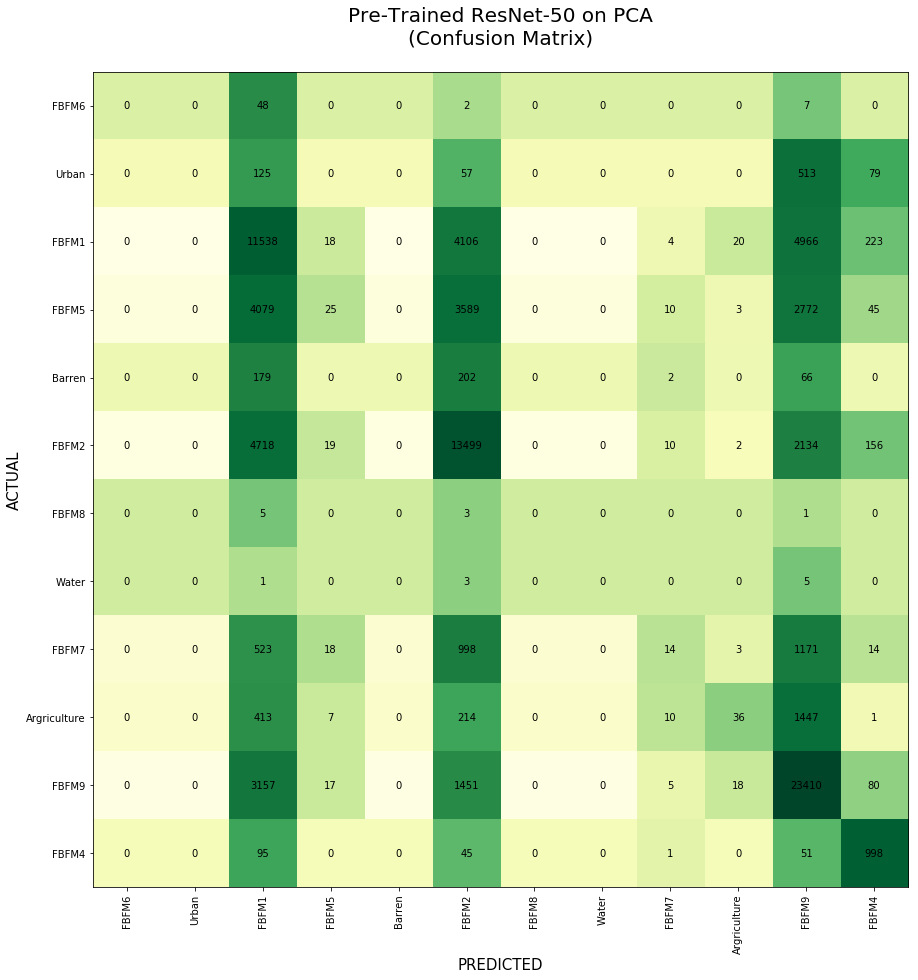

In [131]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = df.Labels.unique()
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on PCA\n(Confusion Matrix)\n', fontsize=20);

#### Validation Score

In [132]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

56.638949571662224

#### Optimal Parameters

In [133]:
classifier.best_params_

{'loss': 'log', 'penalty': 'l2'}

## High Frequency Classes 

In [6]:
high_dist_class_list = ['FBFM1','FBFM2','FBFM5','Urban']

In [8]:
df_high_class = df[df.Labels.isin(high_dist_class_list)]
high_class_idx = np.array(df_high_class.index)

In [153]:
n_samples = len(df)
X = normalize(image_features.values[high_class_idx])
y = np.array(labels)[high_class_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [137]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1)
parameters = {'loss':('log','hinge'),
             'penalty':('l1','l2','none')}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2', 'none'), 'loss': ('log', 'hinge')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [138]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

#### Validation Score

In [139]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

57.61915110201187

In [140]:
classifier.best_params_

{'loss': 'log', 'penalty': 'none'}

## High Frequency with PCA

#### Original Dimensions

In [141]:
from sklearn.decomposition import PCA

M = normalize(image_features.values[high_class_idx])

pca = PCA(n_components=np.shape(M)[1]) 
T = pca.fit_transform(M) 
T.shape

(400482, 1000)

#### Variance Capture by PCA

[ 0.31903109  0.10798433  0.07023989  0.04953367  0.03683915  0.02252522
  0.02027829  0.01879936  0.0162935   0.01544173]


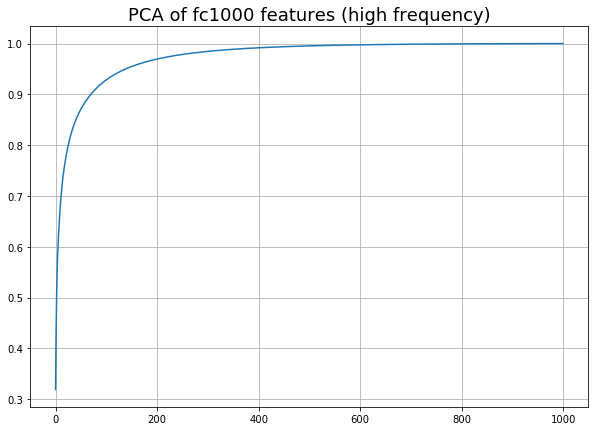

In [142]:
cumulative_explained = np.cumsum(pca.explained_variance_ratio_) 
plt.figure(figsize=(10,7))
plt.plot(cumulative_explained);
#xlim([0,365])
plt.grid()
plt.title('PCA of fc1000 features (high frequency)', fontsize=18)

print(pca.explained_variance_ratio_[:10])

In [143]:
pca = PCA(n_components=400) 
T = pca.fit_transform(M) 

In [144]:
n_samples = len(df)
X = normalize(T)
y = np.array(labels)[high_class_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [145]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2')}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'loss': ('hinge', 'log')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [146]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

#### Validation Score

In [147]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

61.264466833963816

#### Optimal Parameters

In [148]:
classifier.best_params_

{'loss': 'log', 'penalty': 'l2'}

## Analyze Iterations at High Frequency and PCA

In [103]:
pca = PCA(n_components=400) 
T = pca.fit_transform(M) 

In [104]:
X = normalize(T)
y = np.array(labels)[high_class_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [108]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2','none'),
              'n_iter':range(1,10)}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5, n_jobs=-1)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ('l1', 'l2', 'none'), 'loss': ('hinge', 'log'), 'n_iter': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [109]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

#### Validation Score

In [110]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

62.293219471390934

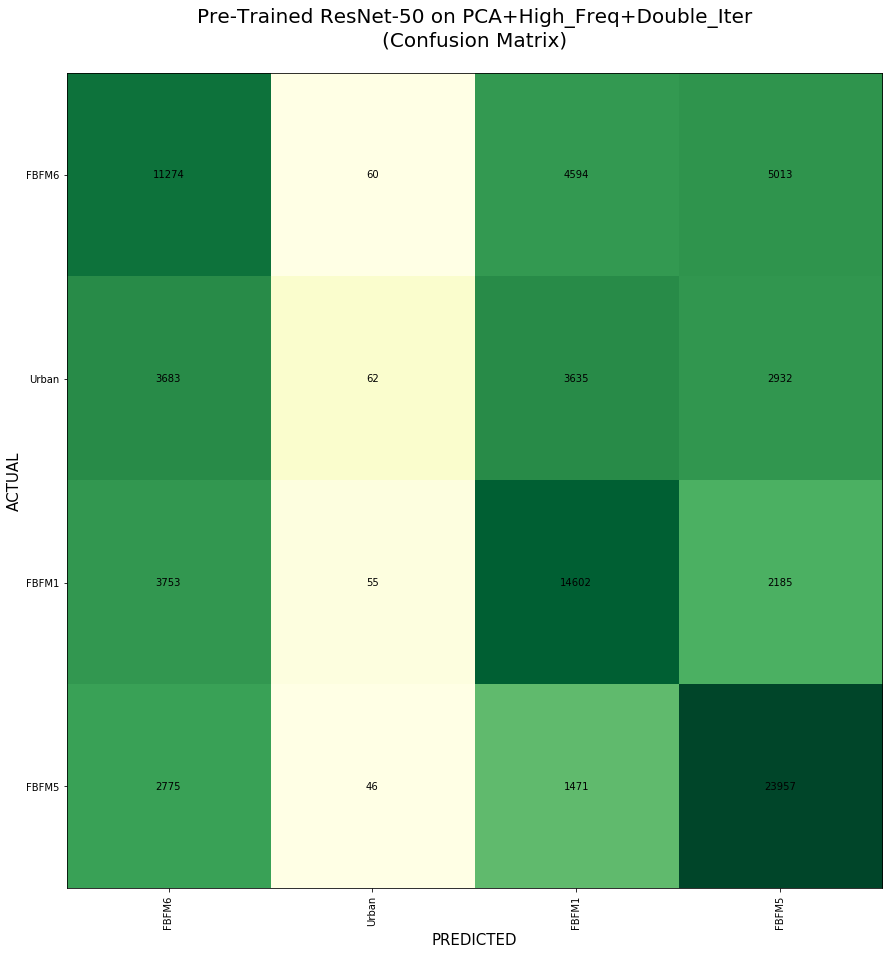

In [112]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = df.Labels.unique()
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on PCA+High_Freq+Double_Iter\n(Confusion Matrix)\n', fontsize=20);

#### Optimal Parameters

In [113]:
classifier.best_params_

{'loss': 'log', 'n_iter': 6, 'penalty': 'none'}

# Analyze Learning Curve

In [118]:
from sklearn.model_selection import learning_curve

X = normalize(T)
y = np.array(labels)[high_class_idx]
clf = SGDClassifier(n_jobs=-1, loss='log', n_iter=6, penalty='none')
train_percent = np.array([0.40,0.50,0.60,0.70,0.80,0.90,1.])
                         
train_sizes, train_scores, valid_scores = learning_curve(clf, X, y, cv=5, train_sizes=train_percent)    

Optimal Score:	 0.62084748302


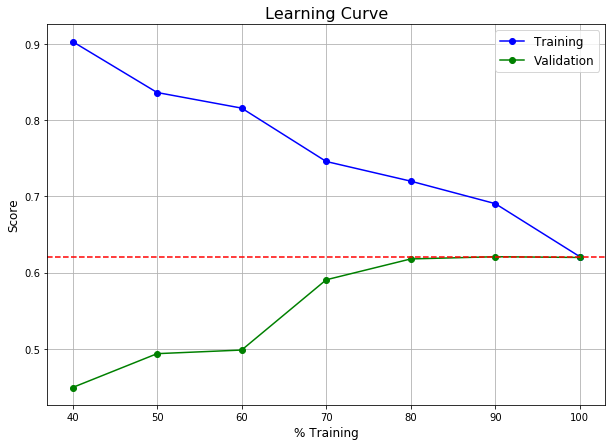

In [119]:
train_av = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

valid_av = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10,7))
plt.plot(train_percent*100, train_av, 'bo-', label="Training")
plt.plot(train_percent*100, valid_av, 'go-', label="Validation")
plt.xlabel('% Training',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.axhline(y=train_av[-1], color = 'r', linestyle ='--')
plt.title('Learning Curve',fontsize=16)
plt.legend(fontsize=12)
plt.grid()
print('Optimal Score:\t',train_av[-1])